In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
from math import sqrt
from statsmodels.stats.power import TTestIndPower
from statsmodels.stats.power import TTestPower
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
%pip install bioinfokit
from bioinfokit.analys import stat
%pip install pingouin
import pingouin as pg
%pip install dfply
from dfply import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 911.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for bioinfokit: filename=bioinfokit-2.1.3-py3-none-any.whl size=59056 sha256=ce38034564c1fc41b01516814937d1f69055527c3dc18890cfcd7003e79e703f
  Stored in directory: /root/.cache/pip/wheels/ac/67/a7/4e0b4172d5415933127e819d7d7080ae08a6220949ad2f6de5
Successfully built bioinfokit
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.4/612.4 kB 8.1 MB/s eta 0:00:00


In [3]:
df = pd.read_csv('INF2178_A4_data.csv')
mri = df.copy()

mri.head()
# subject ID = unique identifier for subject
# MRI ID = unique identifier for subject's MRI scan
# group = demented or nondemented
# visit = subject's nth visit
# MR Delay = ?
# M/F = gender
# Hand = handedness, for this dataset is all R
# Age = age
# EDUC = years of education
# SES = socioeconomic status
# MMSE = mini mental state examination
# CDR = clinical dementia rating
# eTIV = estimated total intracranial volume
# nWBV = normalize whole brain volume
# ASF = atlas scaling factor

,Unnamed: 0,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,5,OAS2_0004,OAS2_0004_MR1,Nondemented,1,0,F,R,88,18,3.0,28.0,0.0,1215,0.710,1.444


In [4]:
mri = mri.set_index(mri.columns[0])
mri.index.name = None

In [5]:
mri.info()

<class 'pandas.core.frame.DataFrame'>
Index: 294 entries, 0 to 371
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  294 non-null    object 
 1   MRI ID      294 non-null    object 
 2   Group       294 non-null    object 
 3   Visit       294 non-null    int64  
 4   MR Delay    294 non-null    int64  
 5   M/F         294 non-null    object 
 6   Hand        294 non-null    object 
 7   Age         294 non-null    int64  
 8   EDUC        294 non-null    int64  
 9   SES         279 non-null    float64
 10  MMSE        293 non-null    float64
 11  CDR         294 non-null    float64
 12  eTIV        294 non-null    int64  
 13  nWBV        294 non-null    float64
 14  ASF         294 non-null    float64
dtypes: float64(5), int64(5), object(5)
memory usage: 36.8+ KB


In [6]:
# slice MRI ID to exclude subject ID
# drop column Visit and Hand
# rename column M/F to Gender

mri['MRI ID'] = mri['MRI ID'].apply(lambda x: x[-3:])
mri = mri.drop(['Visit', 'Hand'], axis=1)
mri = mri.rename(columns={'M/F': 'Gender'})

In [7]:
mri.head()

,Subject ID,MRI ID,Group,MR Delay,Gender,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,MR1,Nondemented,0,M,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,MR2,Nondemented,457,M,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,MR1,Demented,0,M,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,MR2,Demented,560,M,76,12,NaN,28.0,0.5,1738,0.713,1.010
5,OAS2_0004,MR1,Nondemented,0,F,88,18,3.0,28.0,0.0,1215,0.710,1.444


In [8]:
# get breakdown of different categories for visit 1 vs. 2
group = mri.pivot_table(index='Group', columns='MRI ID', aggfunc='size')
group

MRI ID,MR1,MR2
Group,,
Converted,14,12
Demented,64,62
Nondemented,72,70


In [9]:
# split df into first vs second visit

first_mri = mri.loc[mri['MRI ID'] == 'MR1']
second_mri = mri.loc[mri['MRI ID'] == 'MR2']

# get n of individuals by visit
subjects_n = mri.pivot_table(index='MRI ID', columns='Gender', aggfunc='size')
subjects_n['Total'] = mri.groupby('MRI ID').size()
subjects_n

Gender,F,M,Total
MRI ID,,,
MR1,88,62,150
MR2,85,59,144


In [10]:
def round_p_val(val):
  if val < 0.001:
    val = '< 0.001'
  else:
    val = round(val, 3)
  return val

def round_table(df):
  rounded_df = df.copy()
  for col in rounded_df:
    if (rounded_df[col].dtype == 'float64') or (rounded_df[col].dtype == 'int64'):
      rounded_df[col] = rounded_df[col].apply(lambda x: round_p_val(x) if not math.isnan(x) else x)
  return rounded_df

In [11]:
# get summary statistics of relevant variables for first visit

def summary_table(df):
  summary_table = pd.DataFrame({'Statistic': ['Mean', 'Median', 'Min_Value', 'Max_Value', 'Quartile_1', 'Quartile_3']})
  for col in df:
    if df[col].dtypes != 'object':
      col_stats = [np.mean(df[col]), np.median(df[col]), df[col].min(),
                   df[col].max(), df[col].quantile(0.25), df[col].quantile(0.75)]
      summary_table[col] = col_stats
  summary_table = round_table(summary_table)
  return summary_table

summary_table(first_mri.iloc[:, 5:])

,Statistic,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,Mean,75.447,14.533,2.493,27.56,0.26,1474.427,0.736,1.206
1,Median,75.000,14.000,NaN,29.00,< 0.001,1453.500,0.735,1.208
2,Min_Value,60.000,6.000,1.000,17.00,< 0.001,1123.000,0.660,0.883
3,Max_Value,96.000,23.000,5.000,30.00,1.0,1987.000,0.837,1.563
4,Quartile_1,70.000,12.000,2.000,26.00,< 0.001,1347.250,0.710,1.121
5,Quartile_3,80.000,16.000,3.000,30.00,0.5,1565.250,0.758,1.303


In [12]:
# get summary statistics of relevant variables for second visit

summary_table(second_mri.iloc[:, 5:])

,Statistic,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,Mean,77.417,14.59,2.489,26.944,0.344,1483.465,0.726,1.200
1,Median,78.000,15.00,NaN,NaN,< 0.001,1479.000,0.724,1.187
2,Min_Value,62.000,6.00,1.000,15.000,< 0.001,1106.000,0.646,0.876
3,Max_Value,98.000,23.00,5.000,30.000,2.0,2004.000,0.827,1.587
4,Quartile_1,72.000,12.00,2.000,26.000,< 0.001,1349.250,0.696,1.118
5,Quartile_3,82.250,16.00,3.000,30.000,0.5,1569.000,0.751,1.300


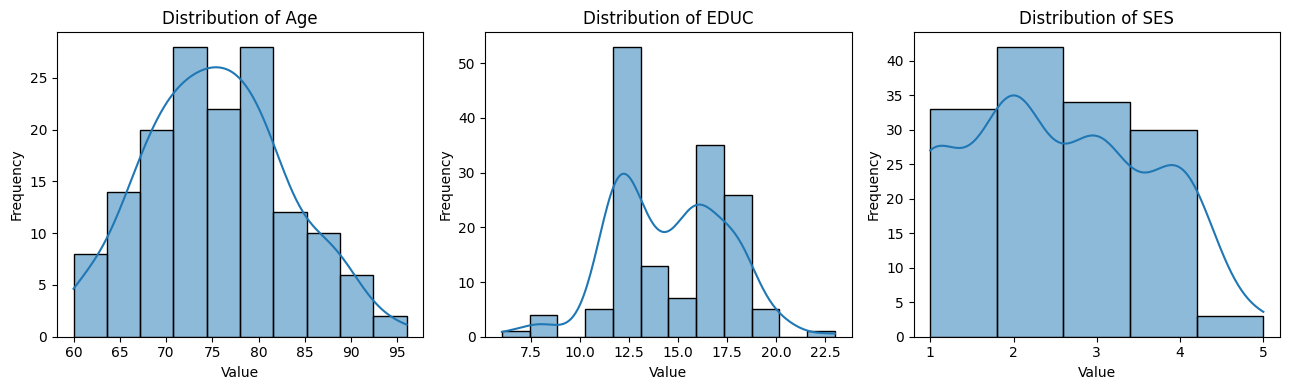

In [13]:
# for eda of demographics, will only use data from first visit
demographics = ['Age', 'EDUC', 'SES']
fig, ax = plt.subplots(1, len(demographics), figsize=[13, 4])
ax_n = 0

for cat in demographics:
  if cat == 'SES':
    sns.histplot(first_mri[cat], bins=5, kde=True, ax=ax[ax_n])
    ax[ax_n].set_xticks([1, 2, 3, 4, 5])
    ax[ax_n].set_xticklabels([1, 2, 3, 4, 5])
  else:
    sns.histplot(first_mri[cat], kde=True, ax=ax[ax_n])
  ax[ax_n].set_title('Distribution of %s' % cat)
  ax[ax_n].set_xlabel('Value')
  ax[ax_n].set_ylabel('Frequency')
  ax_n += 1
plt.tight_layout()

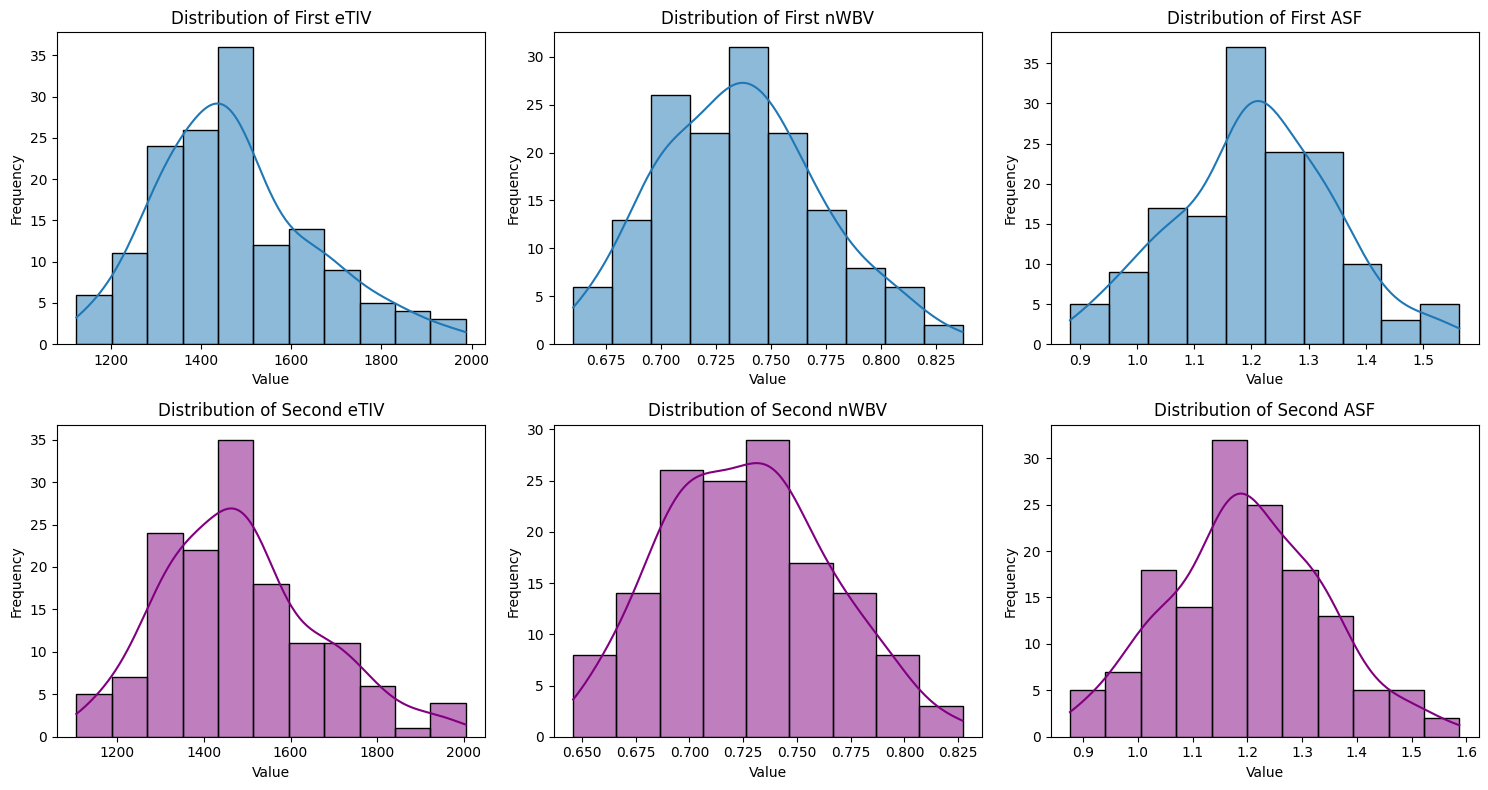

In [14]:
# for brain volume-related tests
brain = ['eTIV', 'nWBV', 'ASF']
fig, ax = plt.subplots(2, len(brain), figsize=[15, 8])
ax_n = 0

# first visit
for cat in brain:
  sns.histplot(first_mri[cat], kde=True, ax=ax[0, ax_n])
  ax[0, ax_n].set_title('Distribution of First %s' % cat)
  ax[0, ax_n].set_xlabel('Value')
  ax[0, ax_n].set_ylabel('Frequency')
  ax_n += 1

ax_n = 0
# second visit
for cat in brain:
  sns.histplot(second_mri[cat], kde=True, color='purple', ax=ax[1, ax_n])
  ax[1, ax_n].set_title('Distribution of Second %s' % cat)
  ax[1, ax_n].set_xlabel('Value')
  ax[1, ax_n].set_ylabel('Frequency')
  ax_n += 1

plt.tight_layout()


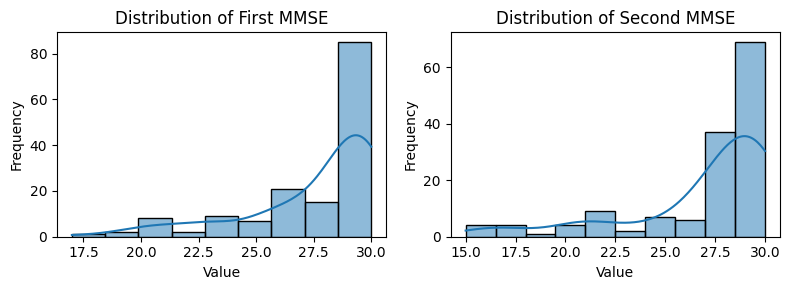

In [15]:
# for diagnostic tests
fig, ax = plt.subplots(1, 2, figsize=[8, 3])

sns.histplot(first_mri['MMSE'], kde=True, ax=ax[0])
ax[0].set_title('Distribution of First MMSE')
ax[0].set_xlabel('Value')
ax[0].set_ylabel('Frequency')

sns.histplot(second_mri['MMSE'], kde=True, ax=ax[1])
ax[1].set_title('Distribution of Second MMSE')
ax[1].set_xlabel('Value')
ax[1].set_ylabel('Frequency')

plt.tight_layout()

In [16]:
list(mri['CDR'].unique())

[0.0, 0.5, 1.0, 2.0]

Text(0.5, 1.0, 'Distribution of CDR Scores by Visit (MRI ID)')

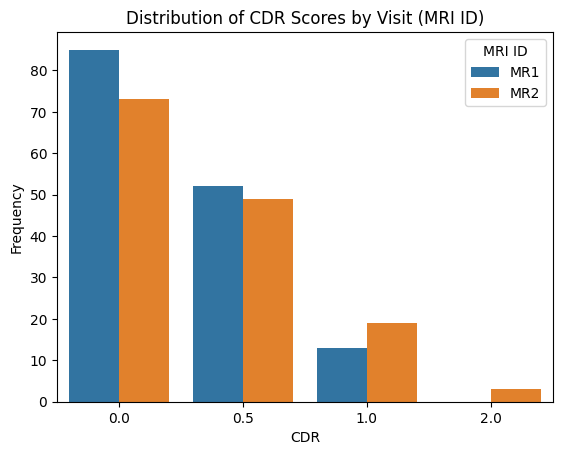

In [17]:
cdr_count = mri.pivot_table(index='CDR', columns='MRI ID', aggfunc='size')
cdr_count['MR1'] = cdr_count['MR1'].fillna(0)
cdr_count = cdr_count.reset_index()

cdr_melt = cdr_count.melt(id_vars='CDR', value_vars=['MR1', 'MR2'], value_name='Frequency')

sns.barplot(data=cdr_melt, x='CDR', y='Frequency', hue='MRI ID')
plt.title('Distribution of CDR Scores by Visit (MRI ID)')

# Question 1
Does MMSE differ depending on SES (between subjects) and over time (within subjects)? \
Dependent Variable: MMSE \
Between Subject Factor: SES \
Within Subject Factor: MRI ID

In [18]:
# create df
mmse_by_ses = mri[['Subject ID', 'MRI ID', 'SES', 'MMSE']].copy()

<ipython-input-19-18f6932392c6>:3: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(data=mmse_by_ses, x='SES', y='MMSE', hue='MRI ID', dodge=True, markers=['o', 's'],


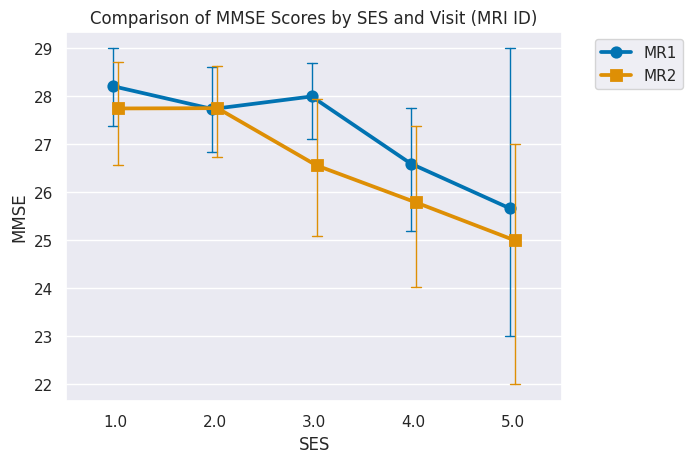

In [19]:
# create point plot
sns.set()
sns.pointplot(data=mmse_by_ses, x='SES', y='MMSE', hue='MRI ID', dodge=True, markers=['o', 's'],
              capsize=.1, errwidth=1, palette='colorblind')
plt.legend(bbox_to_anchor=[1.05, 1], loc='upper left')
plt.title('Comparison of MMSE Scores by SES and Visit (MRI ID)')
plt.show()

Text(0.5, 1.0, 'Distribution of MMSE Scores Across Socioeconomic Status and Visit (MRI ID)')

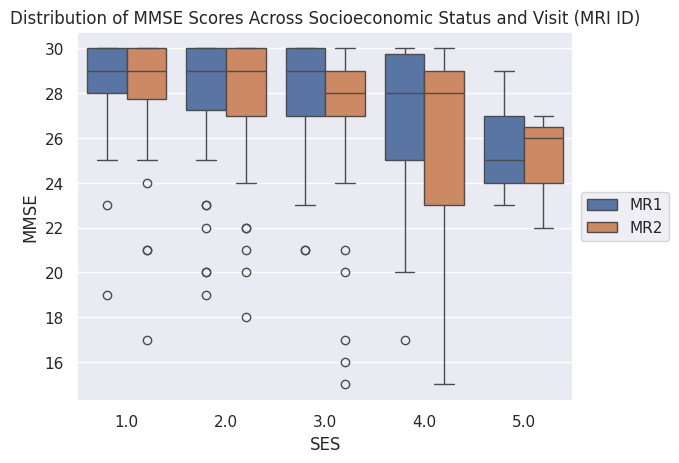

In [20]:
# create boxplot
sns.boxplot(data=mmse_by_ses, x='SES', y='MMSE', hue='MRI ID')
plt.legend(bbox_to_anchor=[1, 0.5], loc='center left')
plt.title('Distribution of MMSE Scores Across Socioeconomic Status and Visit (MRI ID)')

In [21]:
summary_mmse_by_ses = round_table(mri.groupby(['MRI ID', 'SES'])['MMSE'].agg(['mean', 'std']))
summary_mmse_by_ses.T

MRI ID     MR1                                     MR2                  \
SES        1.0     2.0     3.0     4.0     5.0     1.0     2.0     3.0   
mean    28.212  27.738  28.000  26.600  25.667  27.750  27.756  26.562   
std      2.472   3.013   2.535   3.729   3.055   3.152   3.121   4.150   

MRI ID                  
SES        4.0     5.0  
mean    25.793  25.000  
std      4.799   2.646

In [22]:
# anova
aov = pg.mixed_anova(dv='MMSE', within='MRI ID', between='SES', subject='Subject ID', data=mmse_by_ses)
pg.print_table(aov)


ANOVA SUMMARY

Source            SS    DF1    DF2      MS      F    p-unc    np2      eps
-----------  -------  -----  -----  ------  -----  -------  -----  -------
SES          144.174      4    132  36.044  1.729    0.147  0.050  nan
MRI ID        21.639      1    132  21.639  8.898    0.003  0.063    1.000
Interaction   18.864      4    132   4.716  1.939    0.108  0.056  nan



In [23]:
# post-hoc testing
posthocs = pg.pairwise_ttests(dv='MMSE', within='MRI ID', between='SES', subject='Subject ID', data=mmse_by_ses)
results = posthocs[posthocs['p-unc'] < 0.05]
results

/usr/local/lib/python3.10/dist-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,MRI ID,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,MRI ID,-,MR1,MR2,True,True,2.942619,136.000000,two-sided,0.003828,5.825,0.162506
13,MRI ID * SES,MR1,1.0,4.0,False,True,2.036014,48.032666,two-sided,0.047284,1.451,0.525368


In [24]:
# mauchly's test of sphericity
pg.sphericity(data=mmse_by_ses, dv='MMSE', subject='Subject ID', within='MRI ID')[-1]

1.0

In [25]:
# test of normality for each factor
round_table(pg.normality(data=mmse_by_ses, dv='MMSE', group='MRI ID'))

,W,pval,normal
MRI ID,,,
MR1,0.787,< 0.001,False
MR2,0.761,< 0.001,False


In [26]:
round_table(pg.normality(data=mmse_by_ses, dv='MMSE', group='SES'))

,W,pval,normal
SES,,,
2.0,0.731,< 0.001,False
3.0,0.726,< 0.001,False
4.0,0.818,< 0.001,False
1.0,0.725,< 0.001,False
5.0,0.979,0.945,True


In [27]:
# test for homogeneity of variances
first_mmse = mmse_by_ses[mmse_by_ses['MRI ID'] == 'MR1']
first_mmse = first_mmse.reset_index(drop=True)

round_table(pg.homoscedasticity(data=first_mmse, dv='MMSE', group='SES'))

,W,pval,equal_var
levene,1.462,0.217,True


In [28]:
second_mmse = mmse_by_ses[mmse_by_ses['MRI ID'] == 'MR2']
second_mmse = second_mmse.reset_index(drop=True)

round_table(pg.homoscedasticity(data=second_mmse, dv='MMSE', group='SES'))

,W,pval,equal_var
levene,1.148,0.337,True


# Question 2
Does eTIV differ between visits and groups?

In [29]:
# create df
etiv_by_group = mri[['Subject ID', 'MRI ID', 'Group', 'eTIV']].copy()

<ipython-input-30-75c12dc510e0>:2: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(data=etiv_by_group, x='Group', y='eTIV', hue='MRI ID', dodge=True, markers=['o', 's'],


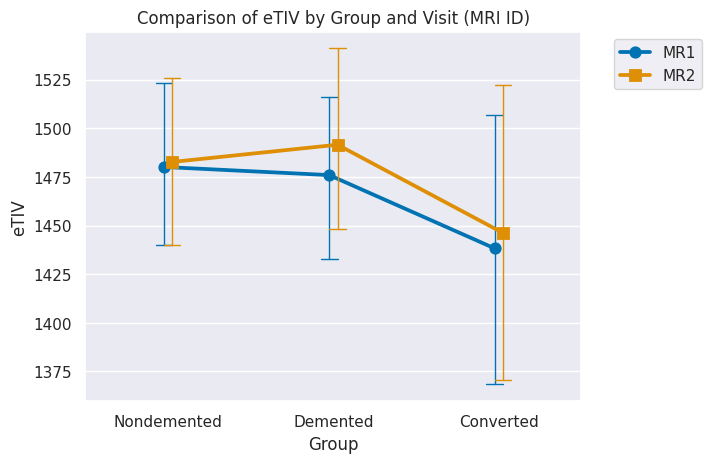

In [30]:
sns.set()
sns.pointplot(data=etiv_by_group, x='Group', y='eTIV', hue='MRI ID', dodge=True, markers=['o', 's'],
              capsize=.1, errwidth=1, palette='colorblind')
plt.legend(bbox_to_anchor=[1.05, 1], loc='upper left')
plt.title('Comparison of eTIV by Group and Visit (MRI ID)')
plt.show()

Text(0.5, 1.0, 'Distribution of eTIV by Group and Visit (MRI ID)')

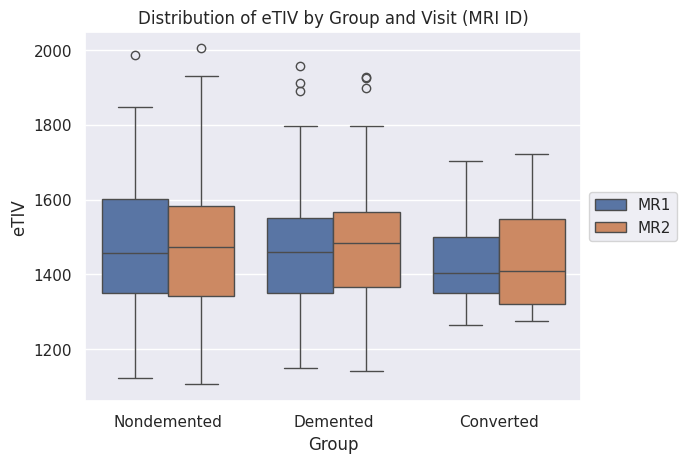

In [31]:
# create boxplot
sns.boxplot(data=etiv_by_group, x='Group', y='eTIV', hue='MRI ID')
plt.legend(loc='center left', bbox_to_anchor=[1, 0.5])
plt.title('Distribution of eTIV by Group and Visit (MRI ID)')

In [32]:
summary_etiv_by_group = round_table(mri.groupby(['MRI ID', 'Group'])['eTIV'].agg(['mean', 'std']))
summary_etiv_by_group.T

MRI ID       MR1                             MR2                      
Group  Converted  Demented Nondemented Converted  Demented Nondemented
mean    1438.286  1475.938    1480.111  1446.250  1491.548    1482.686
std      132.945   173.615     183.747   150.286   177.258     186.320

In [33]:
# anova
aov = pg.mixed_anova(dv='eTIV', within='MRI ID', between='Group', subject='Subject ID', data=etiv_by_group)
pg.print_table(aov)


ANOVA SUMMARY

Source              SS    DF1    DF2         MS      F    p-unc    np2      eps
-----------  ---------  -----  -----  ---------  -----  -------  -----  -------
Group        37424.708      2    141  18712.354  0.297    0.743  0.004  nan
MRI ID        5573.920      1    141   5573.920  9.225    0.003  0.061    1.000
Interaction   1004.783      2    141    502.392  0.831    0.438  0.012  nan



In [34]:
# post-hoc testing
posthocs = pg.pairwise_ttests(dv='eTIV', within='MRI ID', between='Group', subject='Subject ID', data=etiv_by_group)
results = posthocs[posthocs['p-unc'] < 0.05]
results

/usr/local/lib/python3.10/dist-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,MRI ID,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,MRI ID,-,MR1,MR2,True,True,-3.040838,143.0,two-sided,0.002807,7.532,-0.049472


In [35]:
results = posthocs[posthocs['p-unc'] < 0.05]
results

,Contrast,MRI ID,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,MRI ID,-,MR1,MR2,True,True,-3.040838,143.0,two-sided,0.002807,7.532,-0.049472


In [36]:
pg.print_table(posthocs)


POST HOC TESTS

Contrast        MRI ID    A          B            Paired    Parametric         T      dof  alternative      p-unc    BF10    hedges
--------------  --------  ---------  -----------  --------  ------------  ------  -------  -------------  -------  ------  --------
MRI ID          -         MR1        MR2          True      True          -3.041  143.000  two-sided        0.003   7.532    -0.049
Group           -         Converted  Demented     False     True          -0.897   17.630  two-sided        0.382   0.423    -0.249
Group           -         Converted  Nondemented  False     True          -0.796   17.491  two-sided        0.437   0.393    -0.210
Group           -         Demented   Nondemented  False     True           0.159  129.303  two-sided        0.874   0.189     0.027
MRI ID * Group  MR1       Converted  Demented     False     True          -0.863   18.004  two-sided        0.400   0.413    -0.235
MRI ID * Group  MR1       Converted  Nondemented  False    

In [37]:
# mauchly's test of sphericity
pg.sphericity(data=etiv_by_group, dv='eTIV', subject='Subject ID', within='MRI ID')[-1]

1.0

In [38]:
# test of normality
round_table(pg.normality(data=etiv_by_group, dv='eTIV', group='MRI ID'))

,W,pval,normal
MRI ID,,,
MR1,0.969,0.002,False
MR2,0.977,0.016,False


In [39]:
# test of normality
round_table(pg.normality(data=etiv_by_group, dv='eTIV', group='Group'))

,W,pval,normal
Group,,,
Nondemented,0.973,0.006,False
Demented,0.968,0.005,False
Converted,0.918,0.041,False


In [40]:
# test for homogeneity of variances
first_etiv = etiv_by_group[etiv_by_group['MRI ID'] == 'MR1']
first_etiv = first_etiv.reset_index(drop=True)

round_table(pg.homoscedasticity(data=first_etiv, dv='eTIV', group='Group'))

,W,pval,equal_var
levene,0.943,0.392,True


In [41]:
# test for homogeneity of variances
second_etiv = etiv_by_group[etiv_by_group['MRI ID'] == 'MR2']
second_etiv = second_etiv.reset_index(drop=True)

round_table(pg.homoscedasticity(data=second_etiv, dv='eTIV', group='Group'))

,W,pval,equal_var
levene,0.406,0.667,True


# Statistical Power Analysis

In [42]:
# parameters
effect_size = 0.7
alpha = 0.05
power = 0.91

# calculate sample size
obj = TTestIndPower()
n = obj.solve_power(effect_size=effect_size, alpha=alpha, power=power, ratio=1, alternative='two-sided')

print('Sample Size/Number needed in each group: {:.3f}'.format(n))

Sample Size/Number needed in each group: 45.451


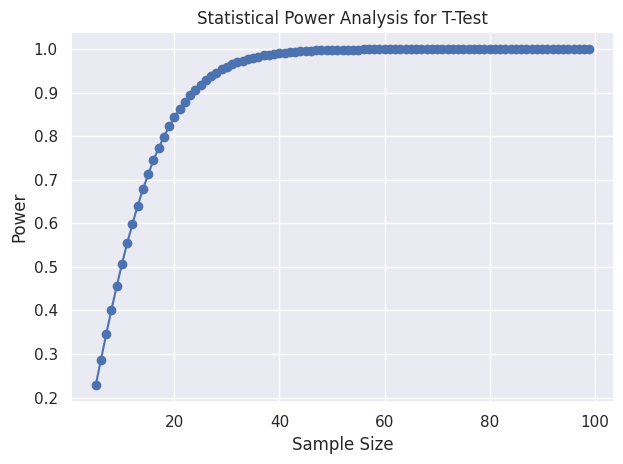

In [43]:
# plot
sample_sizes = np.array(range(5, 100))

power = TTestPower()
powers = power.power(effect_size=effect_size, nobs=sample_sizes, alpha=alpha)

plt.plot(sample_sizes, powers, marker='o')
plt.xlabel('Sample Size')
plt.ylabel('Power')
plt.title('Statistical Power Analysis for T-Test')
plt.grid(True)
plt.tight_layout()
plt.show()